In [1]:
!pip install lightgbm==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [2]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/distan_lat43.302lon-8.377p4R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [3]:
#@title Load station (present weather). Load meteorological model forecast D0.
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/LECOY2018Y2022.csv",
                          usecols =["time","skyc1_o"],
                          parse_dates=["time"]).dropna().set_index("time")
#drop /// cloud cover
station = station[station.skyc1_o!="///"]
print("Cloud cover frequencies")
display(station["skyc1_o"].value_counts(normalize=True).map(lambda n: '{:.0%}'.format(n)))

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")



#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).dropna().replace('VV ', 'VV')
df_all["skyc1_o"] = pd.Categorical(df_all["skyc1_o"])




Cloud cover frequencies


skyc1_o
FEW    34%
M      26%
SCT    18%
BKN    12%
OVC     4%
NSC     3%
NCD     2%
VV      1%
Name: proportion, dtype: object

Round 0


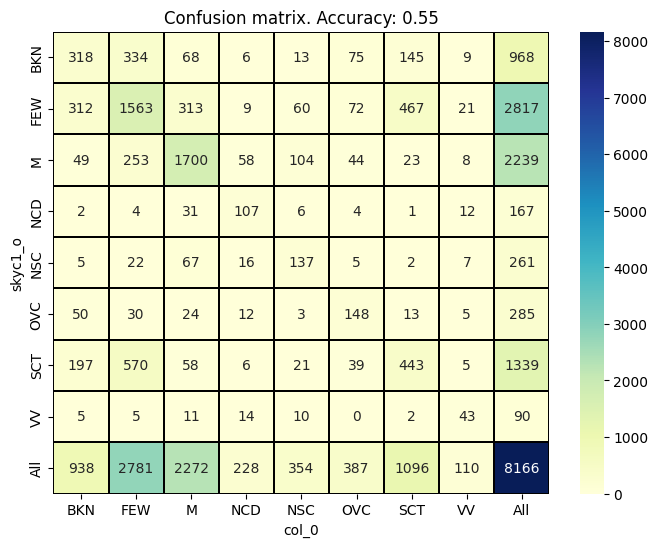

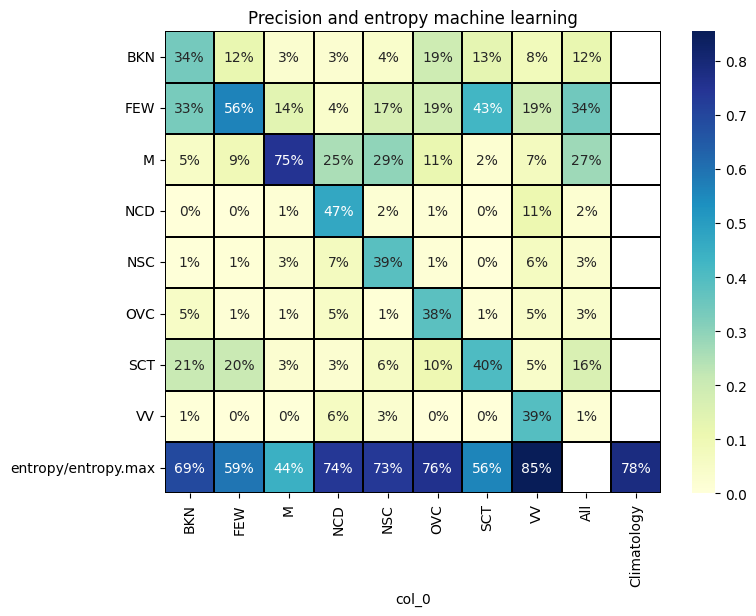

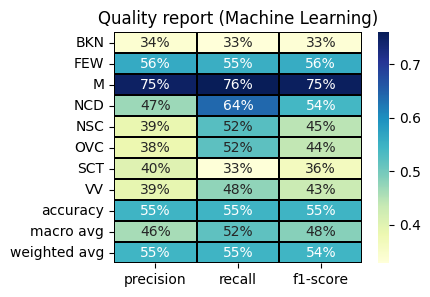

,feature,feature_per
102,dayofyear,3.0%
100,hour,2.7%
50,dir2,1.9%
0,dir0,1.9%
25,dir1,1.7%
52,snowlevel2,1.6%
75,dir3,1.6%
27,snowlevel1,1.5%
33,visibility1,1.4%
39,shflx1,1.4%


Round 1


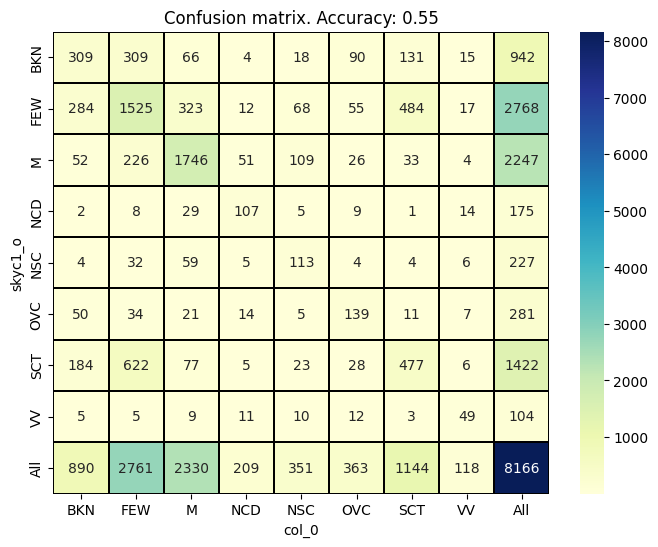

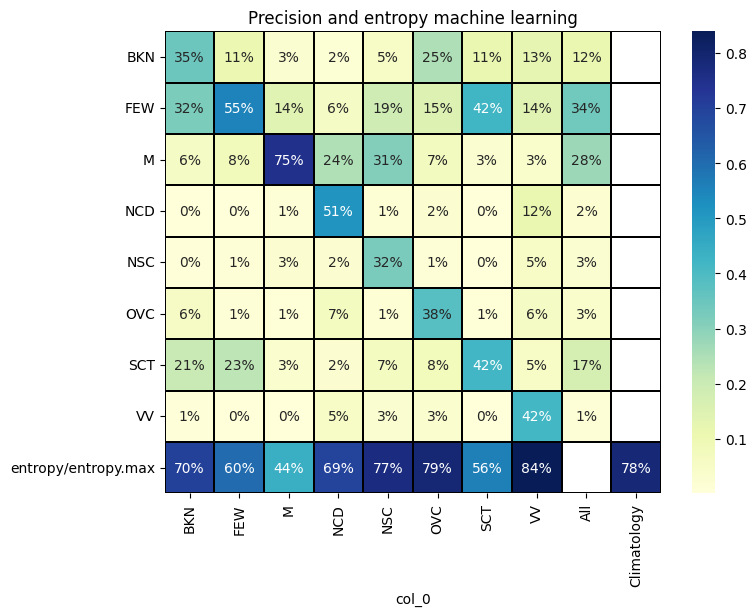

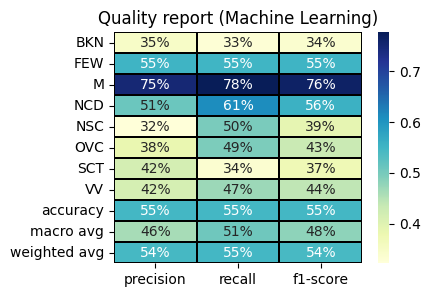

,feature,feature_per
102,dayofyear,3.0%
100,hour,2.8%
0,dir0,2.0%
50,dir2,1.8%
75,dir3,1.7%
25,dir1,1.7%
57,rh2,1.5%
64,shflx2,1.5%
2,snowlevel0,1.5%
5,mslp0,1.4%


Round 2


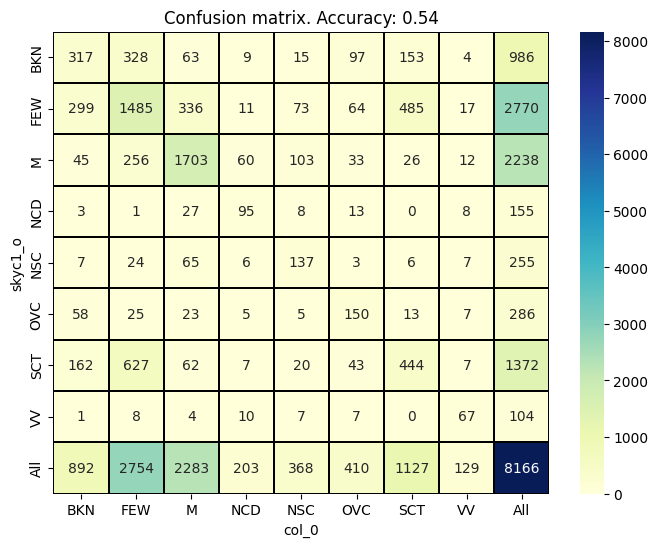

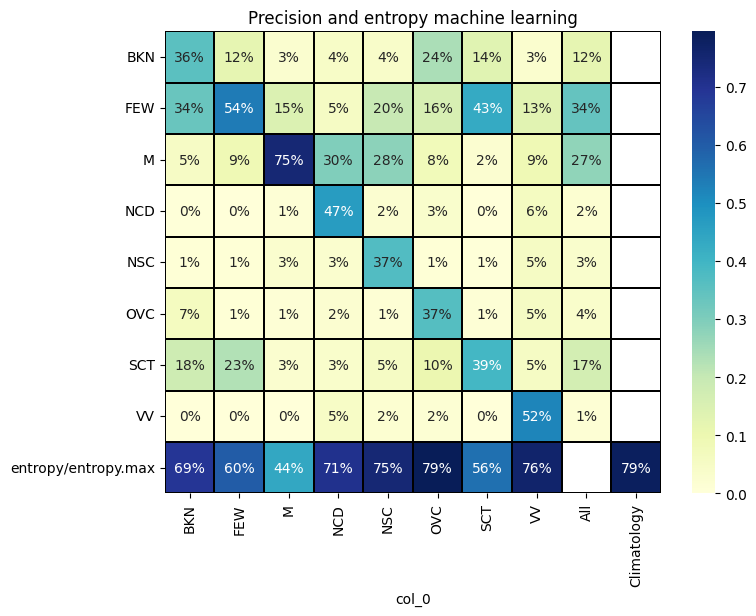

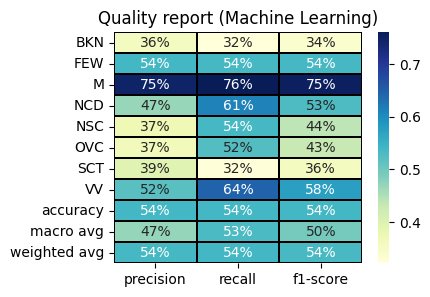

,feature,feature_per
102,dayofyear,2.8%
100,hour,2.7%
0,dir0,2.0%
50,dir2,1.9%
75,dir3,1.7%
25,dir1,1.6%
57,rh2,1.5%
5,mslp0,1.5%
8,visibility0,1.5%
52,snowlevel2,1.4%


Round 3


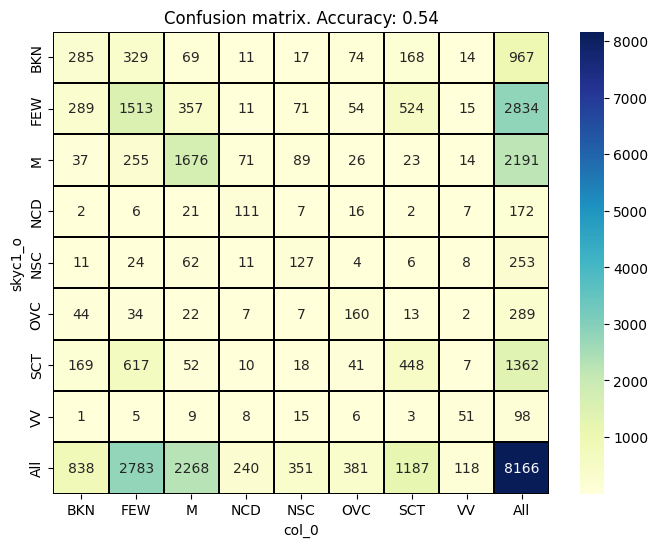

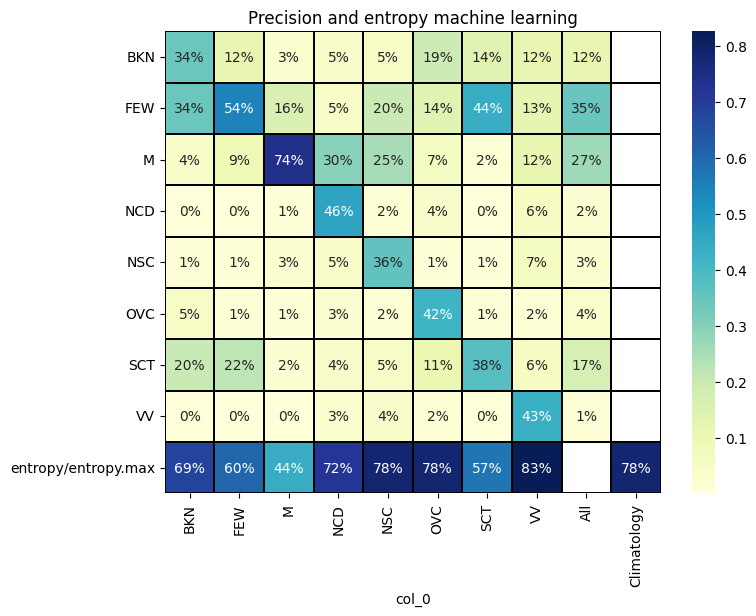

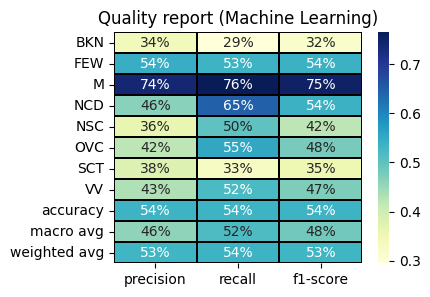

,feature,feature_per
102,dayofyear,2.9%
100,hour,2.7%
0,dir0,2.0%
50,dir2,1.8%
75,dir3,1.7%
5,mslp0,1.5%
57,rh2,1.5%
52,snowlevel2,1.5%
39,shflx1,1.5%
8,visibility0,1.5%



Accuracy stadistics
       Accuracy
count  4.000000
mean   0.545000
std    0.005774
min    0.540000
25%    0.540000
50%    0.545000
75%    0.550000
max    0.550000
Shapiro test normality
p value: 0.02385682798922062
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 2.595044837076059e-52
Significance level: 0.01
Degres of of freedom:  1
Stadistic 231.65626249562143
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 7.65 minutes


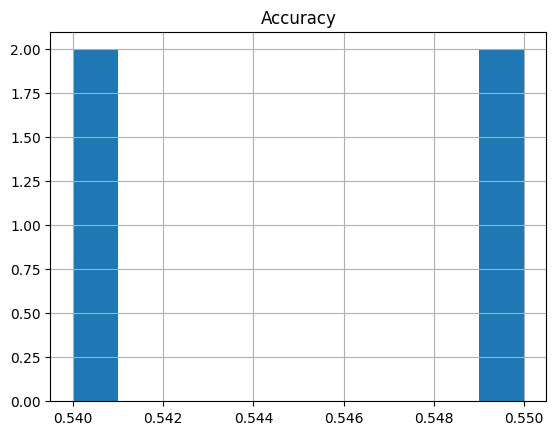

In [4]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro
import math
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.skyc1_o
X = df_all.iloc[:,1:]


# loop random
acc_ml = []
for t in range (0,4):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)

  plt.figure(figsize=(8, 6))
  plt.title("Confusion matrix. Accuracy: {}".format(round(acc_ml[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #Precision and entropy
  plt.figure(figsize=(8, 6))
  plt.title("Precision and entropy machine learning")

  column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
  entropy_values = pd.DataFrame(
    entropy(column_sc, base=2) / (math.log2(column_sc.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc.columns).T
  column_sc = pd.concat([column_sc, entropy_values.rename(columns={"All": "Climatology"})])
  seab = sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nAccuracy stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(acc_ml,columns=["Accuracy"]).describe())

#sample less 5000
sta, p = shapiro(acc_ml)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(acc_ml,columns=["Accuracy"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [5]:
#@title Save last algorithm


x_var = X.columns
score = {"acc_ml":acc_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/algorithms/llmskyc1_LECO_d0.al", 'wb'))

In [ ]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro
import math
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.skyc1_o
X = df_all.iloc[:,1:]



# loop random
acc_ml = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)

  plt.figure(figsize=(8, 6))
  plt.title("Confusion matrix. Accuracy: {}".format(round(acc_ml[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #Precision and entropy
  plt.figure(figsize=(8, 6))
  plt.title("Precision and entropy machine learning")

  column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
  entropy_values = pd.DataFrame(
    entropy(column_sc, base=2) / (math.log2(column_sc.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc.columns).T
  column_sc = pd.concat([column_sc, entropy_values.rename(columns={"All": "Climatology"})])
  seab = sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nAccuracy stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(acc_ml,columns=["Accuracy"]).describe())

#sample less 5000
sta, p = shapiro(acc_ml)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(acc_ml,columns=["Accuracy"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")








Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"acc_ml":acc_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/algorithms/llmskyc1_LEST_d0.al", 'wb'))

In [ ]:
#@title Load meteorological model forecast D1. ML LGBMClassifier. Samples 10. Heidke Skill score.
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).dropna()
df_all["skyc1_o"] = pd.Categorical(df_all["skyc1_o"])

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.skyc1_o
X = df_all.iloc[:,1:]


# loop random
acc_ml = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)

  plt.figure(figsize=(8, 6))
  plt.title("Confusion matrix. Accuracy: {}".format(round(acc_ml[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #Precision and entropy
  plt.figure(figsize=(8, 6))
  plt.title("Precision and entropy machine learning")

  column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
  entropy_values = pd.DataFrame(
    entropy(column_sc, base=2) / (math.log2(column_sc.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc.columns).T
  column_sc = pd.concat([column_sc, entropy_values.rename(columns={"All": "Climatology"})])
  seab = sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nAccuracy stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(acc_ml,columns=["Accuracy"]).describe())

#sample less 5000
sta, p = shapiro(acc_ml)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(acc_ml,columns=["Accuracy"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"acc_ml":acc_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/skyc1_LEST_d1.al", 'wb'))